In [24]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","ggpubr", "mixdist","lubridate")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string
    
options(scipen=10000)

[1] "R version 4.3.2 (2023-10-31)"

# Data

In [25]:
read_excel_allsheets <- function(filename, tibble = FALSE) {
    sheets <- readxl::excel_sheets(filename)
    x <- lapply(sheets, function(X) readxl::read_excel(filename, sheet = X))
    if(!tibble) x <- lapply(x, as.data.frame)
    names(x) <- sheets
    x}

In [26]:
options(warn=-1)
raw_data <- read_excel_allsheets("../../../Korea_Elimination_Csinensis_2022_personal/data/KDCA_data_2012.xlsx") 
options(warn=0)
                
for (i in 9:length(raw_data)){
    as.numeric(raw_data[[i]]$간흡충) -> raw_data[[i]]$간흡충
    raw_data[[i]] %<>% mutate(간흡충=case_when(간흡충 >=24 ~ c("Pos"), TRUE ~ c("Neg"))) %>% dplyr::select(-'양성\r\n여부')
}
                
do.call("rbind", raw_data) %>% 
rename(site=보건소, postal=행정코드, ward=조사구, household=세대, Csinensis=간흡충) %>%
dplyr::select(site, postal, ward, household, Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11, Csinensis) %>%
mutate(Csinensis=case_when(Csinensis==c("Pos") ~ 1, Csinensis==c("Neg") ~ 0,
                           Csinensis==c("양성") ~ 1, Csinensis==c("음성") ~ 0, TRUE ~ 999)) %>% 
filter(Csinensis < 999) %>% 
rename(birth = Q3, sex=Q2, edu=Q4, occu=Q5, fresh=Q6, ocean=Q7, beef=Q8, pork=Q9, res=Q10, inc=Q11) -> raw_data_all

In [27]:
#### if only the birth month is not available, replace it with June
raw_data_all %<>% 
mutate(birth = case_when(substr(birth,5,6)==c("00") ~ paste0(substr(birth,1,4),c("06")), TRUE ~ birth))

raw_data_all$birth <- as.Date(paste0(raw_data_all$birth,01),format="%Y%m%d")
raw_data_all$postal <- as.numeric(raw_data_all$postal)
raw_data_all %<>% mutate(age = floor(as.numeric(as.Date("2012-10-01")-birth)/365.25),
                         age_group1 = case_when(age <= 19 ~ 1,
                                                age > 19 & age <= 29 ~ 2,
                                                age > 29 & age <= 39 ~ 3,
                                                age > 39 & age <= 49 ~ 4,
                                                age > 49 & age <= 59 ~ 5,
                                                age >= 60 ~ 6)) %>% 
dplyr::select(-c("Q1")) %>% filter(!is.na(postal)) %>% filter(age >=0 & age <= 100)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [28]:
read_excel("../../../Korea_Elimination_Csinensis_2022_personal/data/adm_code.xls", sheet=c("2012년")) -> postal_dt
postal_dt %<>% rename(postal=읍면동코드, postal_1=시도명칭, postal_2=시군구명칭, postal_3=읍면동명칭) %>%
dplyr::select(postal, postal_1, postal_2, postal_3)

merge(raw_data_all, postal_dt, by=c("postal"), all.x=TRUE) %>% filter(!is.na(postal_1)) -> raw_data_detail

# Prevalence of Clonorchis sinensis

In [29]:
## Total
raw_data_detail %>% group_by(age_group1) %>% summarise(Prevalence=sum(Csinensis)/n()) %>% 
na.omit() %>% as.data.frame() %>% mutate(group=c("Total")) %>%
mutate(years = case_when(age_group1==1 ~ c("under 20"), age_group1==2 ~ c("20-29"), age_group1==3 ~ c("30-39"),
                         age_group1==4 ~ c("40-49"), age_group1==5 ~ c("50-59"), 
                         age_group1==6 ~ c("60 and over"))) -> prev_age1 

## Male
raw_data_detail %>% filter(sex==1) %>% group_by(age_group1) %>% summarise(Prevalence=sum(Csinensis)/n()) %>% 
na.omit() %>% as.data.frame() %>% mutate(group=c("Male")) %>%
mutate(years = case_when(age_group1==1 ~ c("under 20"), age_group1==2 ~ c("20-29"), age_group1==3 ~ c("30-39"),
                         age_group1==4 ~ c("40-49"), age_group1==5 ~ c("50-59"), 
                         age_group1==6 ~ c("60 and over"))) -> prev_age1_m

## Female
raw_data_detail %>% filter(sex==2) %>% group_by(age_group1) %>% summarise(Prevalence=sum(Csinensis)/n()) %>% 
na.omit() %>% as.data.frame() %>% mutate(group=c("Female")) %>%
mutate(years = case_when(age_group1==1 ~ c("under 20"), age_group1==2 ~ c("20-29"), age_group1==3 ~ c("30-39"),
                         age_group1==4 ~ c("40-49"), age_group1==5 ~ c("50-59"), 
                         age_group1==6 ~ c("60 and over"))) -> prev_age1_f

do.call("rbind", list(prev_age1, prev_age1_m, prev_age1_f)) -> prev_age1_total

In [30]:
prev_age1_total$group <- factor(prev_age1_total$group, levels=c("Total", "Male", "Female"))
prev_age1_total$years <- factor(prev_age1_total$years, levels=c("under 20", "20-29", "30-39", "40-49",
                                                                "50-59", "60 and over"))

options(repr.plot.width=8,repr.plot.height=6)
ggplot(data=prev_age1_total %>% mutate(Prev_per = Prevalence*100), aes(x=years, y=Prev_per, fill=group, width=.75)) +
geom_bar(stat="identity", position=position_dodge()) +
scale_fill_manual("Sex", values = c("Total" = "#FAAB18", "Male" = "#1380A1", "Female" = "#990000")) +
ggtitle("Prevalence of Clonorchis sinensis infection in 2012") +
labs(x="\n Age group", y="Prevalence (%) \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15)) +
coord_cartesian(ylim = c(0, 6)) +
scale_y_continuous(expand = c(0, 0)) -> prev_agegroup1

In [31]:
raw_data_detail %>% group_by(postal_2) %>% 
summarise(Prevalence=sum(Csinensis)/n()) %>% as.data.frame() -> prev_region2

# Proportion of raw freshwater fish consumption

In [32]:
raw_data_detail$fresh <- as.numeric(raw_data_detail$fresh)
raw_data_detail %>% mutate(fresh_val = case_when(fresh==2 ~ 0, fresh==1~1)) %>% na.omit(fresh_val) -> raw_data_detail2

## Total
raw_data_detail2 %>% group_by(age_group1) %>% summarise(Proportion=sum(fresh_val)/n()) %>% 
na.omit() %>% as.data.frame() %>% mutate(group=c("Total")) %>%
mutate(years = case_when(age_group1==1 ~ c("under 20"), age_group1==2 ~ c("20-29"), age_group1==3 ~ c("30-39"),
                         age_group1==4 ~ c("40-49"), age_group1==5 ~ c("50-59"), 
                         age_group1==6 ~ c("60 and over"))) -> prev_fresh1 

## Male
raw_data_detail2 %>% filter(sex==1) %>% group_by(age_group1) %>% summarise(Proportion=sum(fresh_val)/n()) %>% 
na.omit() %>% as.data.frame() %>% mutate(group=c("Male")) %>%
mutate(years = case_when(age_group1==1 ~ c("under 20"), age_group1==2 ~ c("20-29"), age_group1==3 ~ c("30-39"),
                         age_group1==4 ~ c("40-49"), age_group1==5 ~ c("50-59"), 
                         age_group1==6 ~ c("60 and over"))) -> prev_fresh1_m
## Female
raw_data_detail2 %>% filter(sex==2) %>% group_by(age_group1) %>% summarise(Proportion=sum(fresh_val)/n()) %>% 
na.omit() %>% as.data.frame() %>% mutate(group=c("Female")) %>%
mutate(years = case_when(age_group1==1 ~ c("under 20"), age_group1==2 ~ c("20-29"), age_group1==3 ~ c("30-39"),
                         age_group1==4 ~ c("40-49"), age_group1==5 ~ c("50-59"), 
                         age_group1==6 ~ c("60 and over"))) -> prev_fresh1_f

do.call("rbind", list(prev_fresh1, prev_fresh1_m, prev_fresh1_f)) -> prev_fresh1_total

In [33]:
raw_data_detail2 %>% group_by(postal_2) %>% 
summarise(Proportion=sum(fresh_val)/n()) %>% as.data.frame() -> prop_region2

In [34]:
prev_fresh1_total$group <- factor(prev_fresh1_total$group, levels=c("Total", "Male", "Female"))
prev_fresh1_total$years <- factor(prev_fresh1_total$years, levels=c("under 20", "20-29", "30-39", "40-49",
                                                                    "50-59", "60 and over"))

options(repr.plot.width=8,repr.plot.height=6)
ggplot(data=prev_fresh1_total %>% mutate(Prop_per = Proportion*100), 
       aes(x=years, y=Prop_per, fill=group, width=.75)) +
geom_bar(stat="identity", position=position_dodge()) +
scale_fill_manual("Sex", values = c("Total" = "#FAAB18", "Male" = "#1380A1", "Female" = "#990000")) +
ggtitle("Raw freshwater fish consumption behavior in 2012") +
labs(x="\n Age group", y="Proportion (%) \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15)) +
coord_cartesian(ylim = c(0, 40)) +
scale_y_continuous(expand = c(0, 0)) -> prop_agegroup1

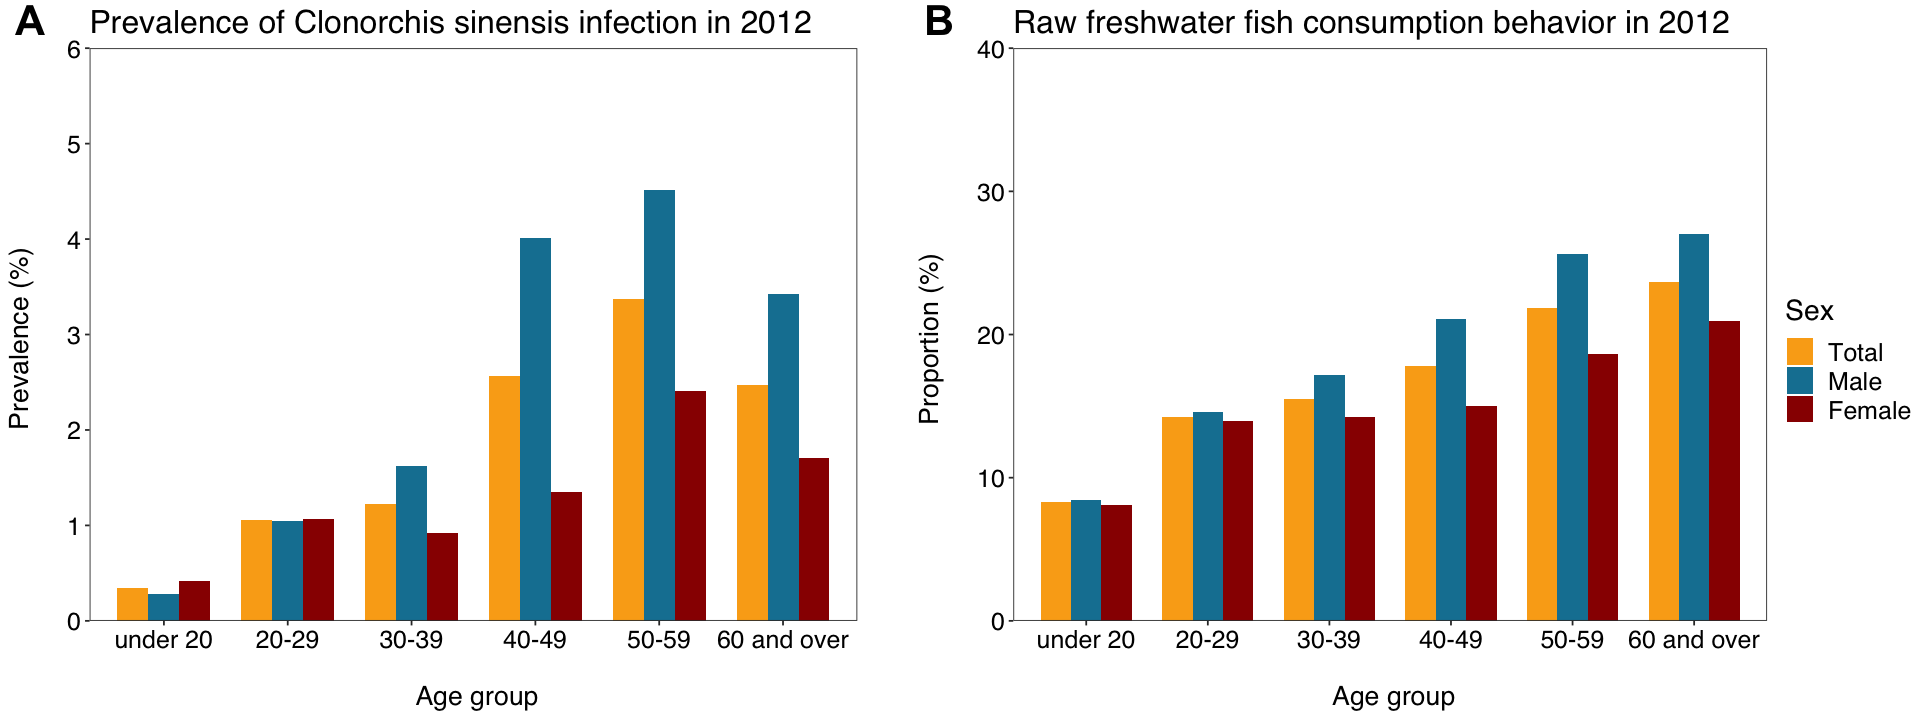

In [35]:
library(ggpubr)
options(repr.plot.width=16,repr.plot.height=6)
ggarrange(prev_agegroup1, ggplot() + theme_void(), prop_agegroup1, 
          ncol = 3, nrow = 1, widths = c(1, 0.05, 1, 0.05, 1),  
          labels = c("A", "", "B"), font.label = list(size = 25), vjust=1.15,
          common.legend = TRUE, legend = "right")

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'



	Pearson's product-moment correlation

data:  corr_dt$Prop_per and corr_dt$Prev_per
t = 3.4342, df = 206, p-value = 0.0007185
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.09982235 0.35742929
sample estimates:
      cor 
0.2327034 


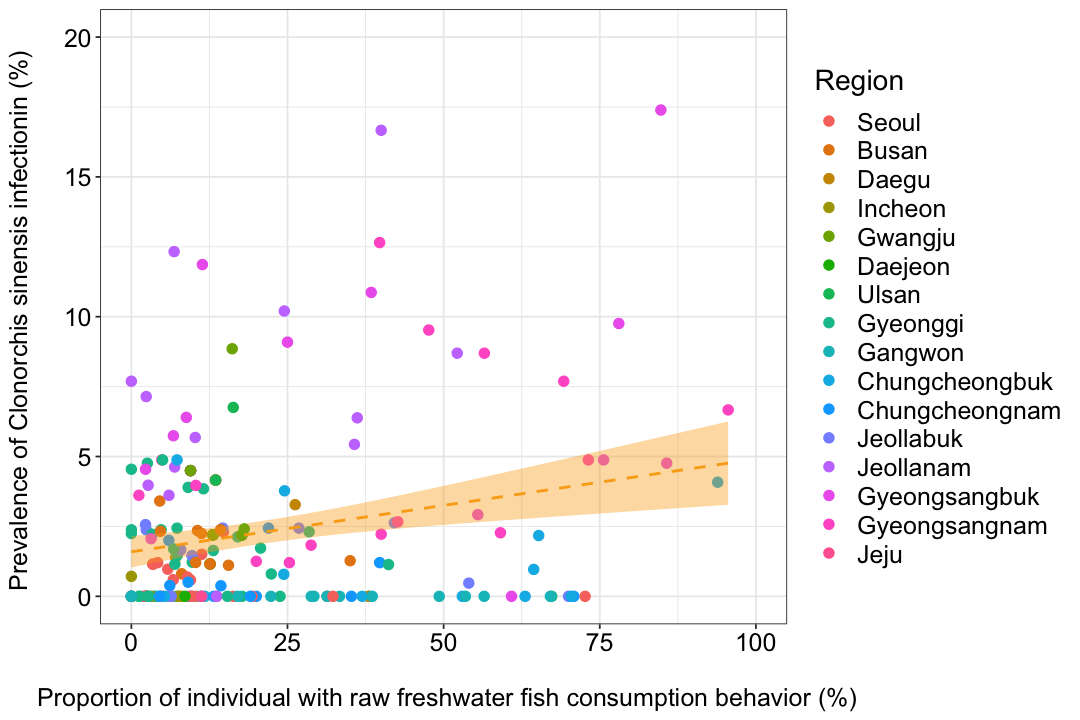

In [36]:
raw_data_detail %>% dplyr::select(postal_1, postal_2) %>% unique() -> address_dt

merge(prop_region2, prev_region2, by=c("postal_2")) -> corr_dt
merge(corr_dt, address_dt, by=c("postal_2"), all.x=TRUE) %>% 
mutate(Prop_per=Proportion*100, Prev_per=Prevalence*100) %>%
mutate(Region=
       case_when(postal_1==c("서울특별시") ~ c("Seoul"), postal_1==c("인천광역시") ~ c("Incheon"), 
                 postal_1==c("경기도") ~ c("Gyeonggi"), postal_1==c("강원도") ~ c("Gangwon"),
                 postal_1==c("충청남도") ~ c("Chungcheongnam"), postal_1==c("충청북도") ~ c("Chungcheongbuk"),
                 postal_1==c("전라남도") ~ c("Jeollanam"), postal_1==c("전라북도") ~ c("Jeollabuk"),
                 postal_1==c("경상남도") ~ c("Gyeongsangnam"), postal_1==c("경상북도") ~ c("Gyeongsangbuk"),
                 postal_1==c("광주광역시") ~ c("Gwangju"), postal_1==c("부산광역시") ~ c("Busan"),
                 postal_1==c("대구광역시") ~ c("Daegu"), postal_1==c("울산광역시") ~ c("Ulsan"),
                 postal_1==c("대전광역시") ~ c("Daejeon"), postal_1==c("제주특별자치도") ~ c("Jeju"))) -> corr_dt

corr_dt$Region <- factor(corr_dt$Region, 
                         levels=c("Seoul", "Busan", "Daegu", "Incheon", "Gwangju", "Daejeon", "Ulsan",
                                  "Gyeonggi", "Gangwon", "Chungcheongbuk", "Chungcheongnam", 
                                  "Jeollabuk", "Jeollanam", "Gyeongsangbuk", "Gyeongsangnam", "Jeju"))

options(warn=-1, repr.plot.width=9,repr.plot.height=6)
corr_dt %>% #filter(Region!=c("Gangwon-do")) %>%
ggplot() + 
geom_point(aes(x = Prop_per, y = Prev_per, color = Region), 
           size=4, shape = 20) +
geom_smooth(aes(x = Prop_per, y = Prev_per), 
            method=lm, linetype = "dashed", size=0.8, colour="#FAAB18", fill="#FAAB18")  +
labs(x="\n Proportion of individual with raw freshwater fish consumption behavior (%)", 
     y="Prevalence of Clonorchis sinensis infectionin (%) \n") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=18, color="black"),
      axis.title = element_text(size=15, color="black"),
      axis.text = element_text(size=15, color="black"),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15)) +
coord_cartesian(ylim = c(0, 20), xlim = c(0,100))
ggsave("../../figures/final_figures/FigS2.png", width = 9, height = 6)

cor.test(corr_dt$Prop_per, corr_dt$Prev_per)